In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100].copy()
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1].copy()
            ldms_dataframe.loc[:, metric] = ldms_dataframe[metric] * 100
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

In [5]:
df_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_saact.pq")
df_gputil = preprocess_data(df_gputil, df_sacct_gputil, metric="gpu_utilization", percentage=True)

df_gputil = df_gputil.iloc[:len(df_gputil) // 100]
df_gputil = df_gputil[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'gpu_utilization']]

Number of LDMS data points before preprocessing:  116803958
Number of LDMS data points after preprocessing:  52268361


In [6]:
df_tensor = pd.read_parquet(csv_filepath + "/" + "dcgm.tensor_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_tensor = pd.read_parquet(csv_filepath + "/" + "dcgm.tensor_active.1692169200.1692428399.8.16_saact.pq")
df_tensor = preprocess_data(df_tensor, df_sacct_tensor, metric="tensor_active", percentage=True)

df_tensor = df_tensor.iloc[:len(df_tensor) // 100]
df_tensor = df_tensor[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'tensor_active']]

Number of LDMS data points before preprocessing:  116807383
Number of LDMS data points after preprocessing:  52269956


In [5]:
df_sm_active = pd.read_parquet(csv_filepath + "/" + "dcgm.sm_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_sm_active = pd.read_parquet(csv_filepath + "/" + "dcgm.sm_active.1692169200.1692428399.8.16_saact.pq")
df_sm_active = preprocess_data(df_sm_active, df_sacct_sm_active, metric="sm_active", percentage=True)

df_sm_active = df_sm_active.iloc[:len(df_sm_active) // 20]
df_sm_active = df_sm_active[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'sm_active']]

Number of LDMS data points before preprocessing:  116806253
Number of LDMS data points after preprocessing:  52270259


In [6]:
df_memcpy_utilization = pd.read_parquet(csv_filepath + "/" + "dcgm.mem_copy_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_memcpy_utilization = pd.read_parquet(csv_filepath + "/" + "dcgm.mem_copy_utilization.1692169200.1692428399.8.16_saact.pq")
df_memcpy_utilization = preprocess_data(df_memcpy_utilization, df_sacct_memcpy_utilization, metric="mem_copy_utilization", percentage=True)

df_memcpy_utilization = df_memcpy_utilization.iloc[:len(df_sm_active) // 20]
df_memcpy_utilization = df_memcpy_utilization[['#Time', 'jobid', 'ProducerName', 'gpu_id', 'step', 'mem_copy_utilization']]

Number of LDMS data points before preprocessing:  116806476
Number of LDMS data points after preprocessing:  52275495


## Correlations

- This is preliminary. Calculating correlation requires memory intensive operations.
- The idea is to investigate correlation between different metrics such as:
1. GPU Utilization vs. Tensor Active
2. GPU Utilization vs. SM Occupancy/SM Active
3. GPU Utilization vs. NVLink Bandwidth Total
4. GPU Utilization vs. Memory Metrics (fb_used, fb_free, mem_copy_utilization)
5. Memory Metrics vs SM Occupancy/SM Active

#### GPU Utilization and Tensor Active
- TODO: Remove zero values?? Think about this later. I am not sure what we can learn from this.

In [7]:
merged_heatmap = df_tensor[["#Time", "ProducerName", "gpu_id", "jobid", "step", "tensor_active"]].merge(df_gputil[["#Time", "ProducerName", "gpu_id", "jobid", "step", "gpu_utilization"]], 
                                                                                                on=["#Time", "ProducerName", "gpu_id", "jobid", "step"], how='inner')
merged_heatmap = merged_heatmap.drop_duplicates()
print("Number of rows after 1st merge: ", len(merged_heatmap.index))

Number of rows after 1st merge:  80328


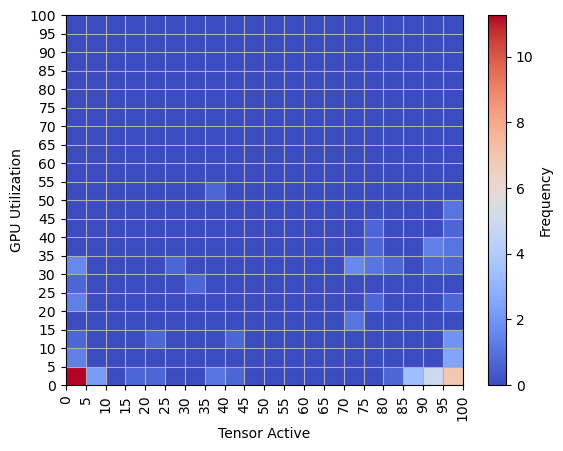

In [8]:
x_axis_data = merged_heatmap["tensor_active"] * 100
y_axis_data = merged_heatmap["gpu_utilization"]

xticks = np.arange(0.0, 100.05, 5)
yticks = np.arange(0.0, 100.05, 5)

hist, xedges, yedges = np.histogram2d(x_axis_data, y_axis_data, bins=(xticks, yticks))
hist = np.log(hist, out=np.zeros_like(hist), where=(hist!=0))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(hist, extent=extent, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(label='Frequency')  # Add color bar with label

# Annotate the heatmap with numbers
# for i in range(len(yedges) - 1):
#     for j in range(len(xedges) - 1):
#         plt.text(xedges[j] + 0.5, yedges[i] + 0.5, int(hist[i, j]),
#                  color='white', ha='center', va='center', fontsize=8)

plt.xlabel('Tensor Active')
plt.ylabel('GPU Utilization')

plt.xticks(xedges, rotation=90)
plt.yticks(yedges)

plt.grid(True)
plt.show()


In [10]:
correlation = merged_heatmap[['gpu_utilization', 'tensor_active']].corr()
correlation

,gpu_utilization,tensor_active
gpu_utilization,1.000000,0.478959
tensor_active,0.478959,1.000000


## Distribution of ratios
- How can we answer the following question: What is the relative benefit of adding more SMs versus increasing memory bandwidth?
- I don't think exploring the distribution of ratios is a very good technique to answer this.

In [7]:
merged_heatmap = df_sm_active[["#Time", "ProducerName", "gpu_id", "jobid", "step", "sm_active"]].merge(df_memcpy_utilization[["#Time", "ProducerName", "gpu_id", "jobid", "step", "mem_copy_utilization"]], 
                                                                                                on=["#Time", "ProducerName", "gpu_id", "jobid", "step"], how='inner')
merged_heatmap = merged_heatmap.drop_duplicates()
print("Number of rows after 1st merge: ", len(merged_heatmap.index))

Number of rows after 1st merge:  49480


In [8]:
merged_heatmap["sm/memcpy"] = merged_heatmap["sm_active"] / merged_heatmap["mem_copy_utilization"]
merged_heatmap.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_heatmap.dropna(subset=["sm/memcpy"], how="all", inplace=True)

In [9]:
merged_heatmap

,#Time,ProducerName,gpu_id,jobid,step,sm_active,mem_copy_utilization,sm/memcpy
2960,1692299110,login01,0,13651012,4294967292,65.4584,50.0,1.309168
3104,1692311130,login01,0,13651012,4294967292,87.3821,47.0,1.859194
233215,1692252010,login01,0,8406623,4294967292,94.9974,64.0,1.484334
234440,1692252020,login01,0,8406623,4294967292,95.3670,55.0,1.733945
235665,1692252030,login01,0,8406623,4294967292,95.5605,45.0,2.123567
...,...,...,...,...,...,...,...,...
494320,1692186700,login04,0,10778925,4294967292,92.7566,7.0,13.250943
494321,1692186710,login04,0,10778925,4294967292,94.2310,3.0,31.410333
3422431,1692310700,login04,0,9484355,4294967291,67.6349,21.0,3.220710
3422435,1692310710,login04,0,9484355,4294967291,68.6248,24.0,2.859367


Text(0.5, 1.0, 'Distribution of SM_ACTIVE/MEM_COPY_UTILIZATION after preprocessing')

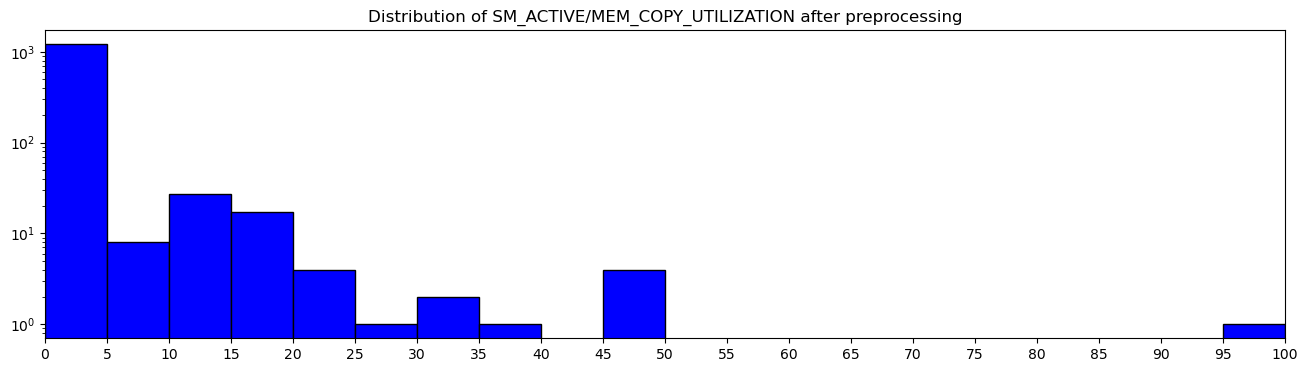

In [13]:
fig, axis = plt.subplots(figsize=(16, 4))
bin_edges = np.arange(0, 105, 5)
hist_values, bin_edges, _ = plt.hist(merged_heatmap["sm/memcpy"], bins=bin_edges, color='blue', edgecolor="black")

axis.set_xlim(0, 100)
plt.xticks(bin_edges)
plt.yscale('log')
plt.title("Distribution of SM_ACTIVE/MEM_COPY_UTILIZATION after preprocessing")

## Distribution of correlations at job level
Potential questions:
- How consistent is the relationship between GPU utilization and tensor activity across different jobs?
- Is the relationship between GPU utilization and tensor activity generally positive, negative, or neutral?
- How do correlations compare across different types of workloads (deep learning vs others)?

In [7]:
merged_tensor_gpu = df_tensor[["#Time", "ProducerName", "gpu_id", "jobid", "step", "tensor_active"]].merge(df_gputil[["#Time", "ProducerName", "gpu_id", "jobid", "step", "gpu_utilization"]], 
                                                                                                on=["#Time", "ProducerName", "gpu_id", "jobid", "step"], how='inner')
merged_tensor_gpu = merged_tensor_gpu.drop_duplicates()
merged_tensor_gpu

,#Time,ProducerName,gpu_id,jobid,step,tensor_active,gpu_utilization
0,1692169210,login01,0,6957798,4294967292,0.0,0.0
1,1692169220,login01,0,6957798,4294967292,0.0,0.0
2,1692169230,login01,0,6957798,4294967292,0.0,0.0
3,1692169240,login01,0,6957798,4294967292,0.0,0.0
4,1692169250,login01,0,6957798,4294967292,0.0,0.0
...,...,...,...,...,...,...,...
29582923,1692400110,login09,0,8406623,4294967291,0.0,0.0
29585039,1692400120,login09,0,8406623,4294967291,0.0,0.0
29587155,1692400130,login09,0,8406623,4294967291,0.0,0.0
29589271,1692400140,login09,0,8406623,4294967291,0.0,0.0


In [ ]:
correlations = merged_tensor_gpu.groupby('jobid').apply(lambda x: x['tensor_active'].corr(x['gpu_utilization'])).reset_index()
correlations.columns = ['jobid', 'correlation']

/global/homes/o/ocankur/.conda/envs/myenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/global/homes/o/ocankur/.conda/envs/myenv/lib/python3.10/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


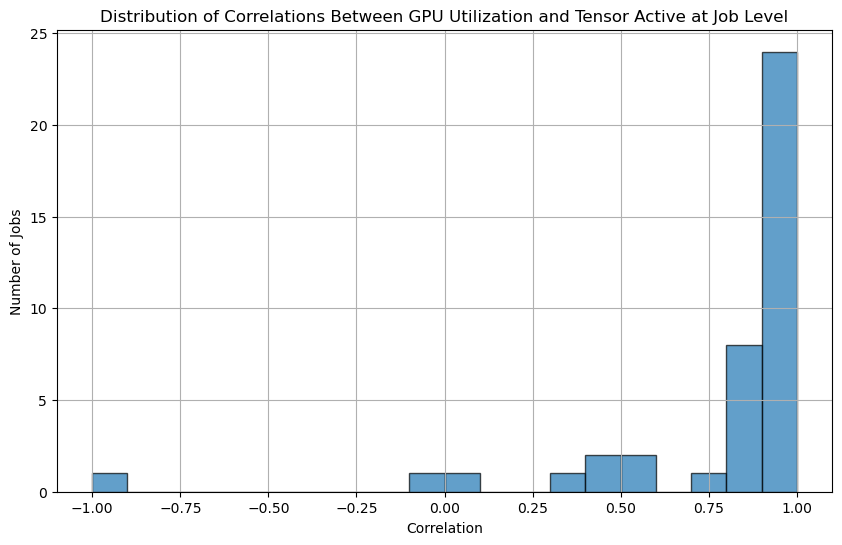

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(correlations['correlation'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Correlations Between GPU Utilization and Tensor Active at Job Level')
plt.xlabel('Correlation')
plt.ylabel('Number of Jobs')
plt.grid(True)
plt.show()

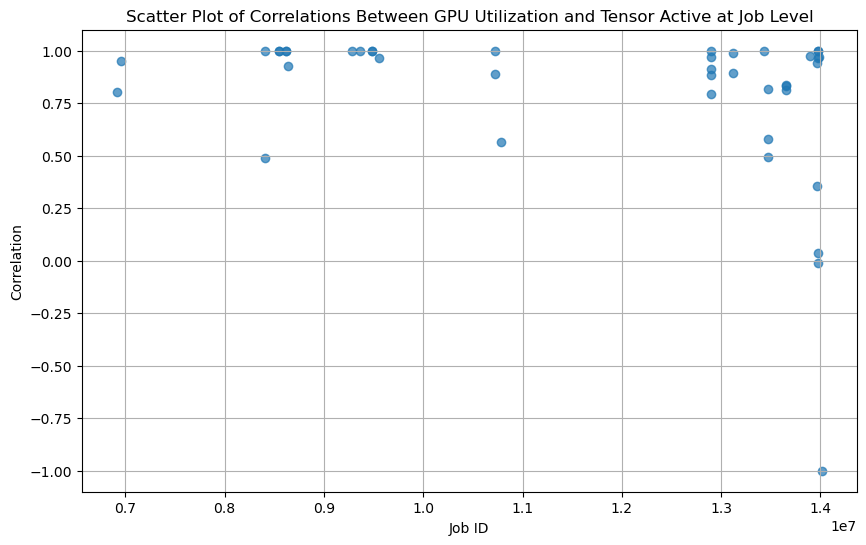

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(correlations['jobid'], correlations['correlation'], alpha=0.7)
plt.title('Scatter Plot of Correlations Between GPU Utilization and Tensor Active at Job Level')
plt.xlabel('Job ID')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

## Cross correlation

Cross-correlation is a measure of similarity between two time series as a function of the lag applied to one of them. It helps identify if one series is correlated with a time-shifted version of another series. 

How?
- Calculate the cross-correlation for different lags by shifting one series relative to the other and computing the correlation at each shift.
- Identify the lag at which the cross-correlation is maximum. This lag represents the time shift that maximizes the similarity between the two series.
- A negative lag indicates that the second series (tensor activity) leads the first series (GPU utilization). In other words, changes in the second series happen before changes in the first series. 

Questions we can ask:
- What is the typical time lag in two different metrics?
- Can the change in one metric predict a subsequent change in another metric?

In [25]:
from scipy import signal

In [ ]:
merged_tensor_gpu.reset_index(drop=True, inplace=True)

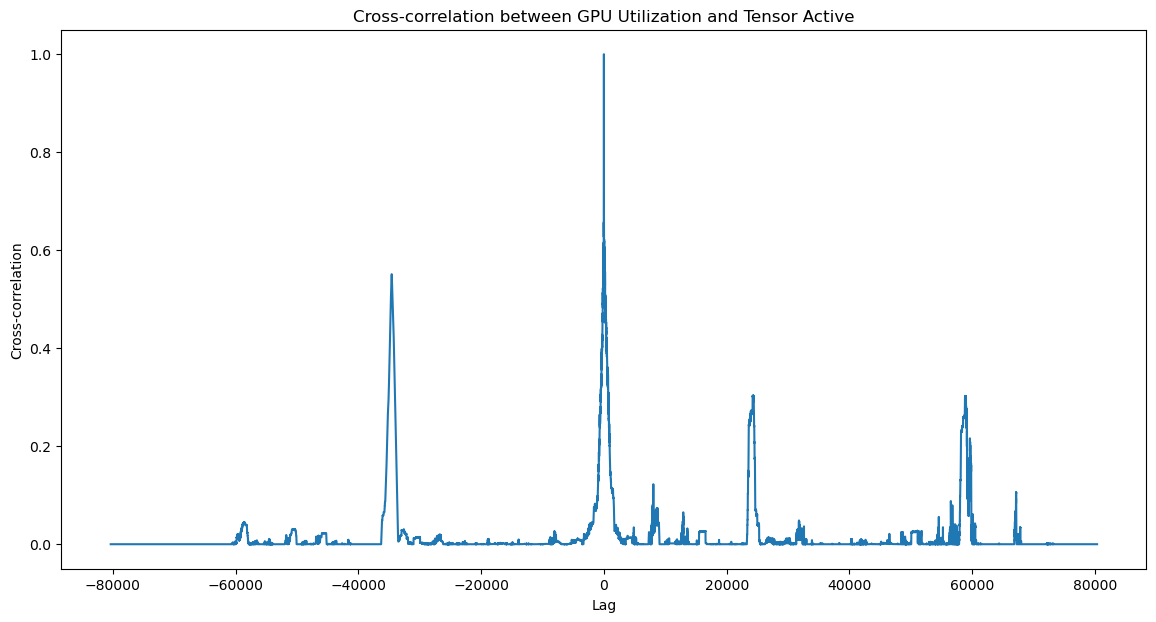

In [44]:
# def detect_peaks(data, threshold=0.9):
#     peaks, _ = signal.find_peaks(data, height=threshold)
#     return peaks

# gpu_peaks = detect_peaks(merged_tensor_gpu['gpu_utilization'])
# tensor_peaks = detect_peaks(merged_tensor_gpu['tensor_active'] * 100)

# plt.figure(figsize=(14, 7))
# # plt.plot(merged_tensor_gpu['#Time'], merged_tensor_gpu['gpu_utilization'], label='GPU Utilization')
# plt.plot(merged_tensor_gpu['#Time'].iloc[gpu_peaks], merged_tensor_gpu['gpu_utilization'].iloc[gpu_peaks], 'x', label='GPU Peaks')
# # plt.plot(merged_tensor_gpu['#Time'], merged_tensor_gpu['tensor_active'], label='Tensor Active')
# plt.plot(merged_tensor_gpu['#Time'].iloc[tensor_peaks], merged_tensor_gpu['tensor_active'].iloc[tensor_peaks], 'o', label='Tensor Peaks')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Peaks in GPU Utilization and Tensor Active')
# plt.show()

corr = signal.correlate(merged_tensor_gpu['gpu_utilization'], merged_tensor_gpu['tensor_active'])
lags = signal.correlation_lags(len(merged_tensor_gpu['gpu_utilization']), len(merged_tensor_gpu['tensor_active']))
# normalizing the cross-correlation values
corr /= np.max(corr)

plt.figure(figsize=(14, 7))
plt.plot(lags, corr)
plt.title('Cross-correlation between GPU Utilization and Tensor Active')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()

In [45]:
# finding the lag with maximum correlation
max_corr_index = np.argmax(corr)
lag = lags[max_corr_index]
lag, corr[max_corr_index]

(0, 1.0)

/tmp/ipykernel_500472/521490797.py:7: RuntimeWarning: invalid value encountered in true_divide
  corr /= np.max(corr)


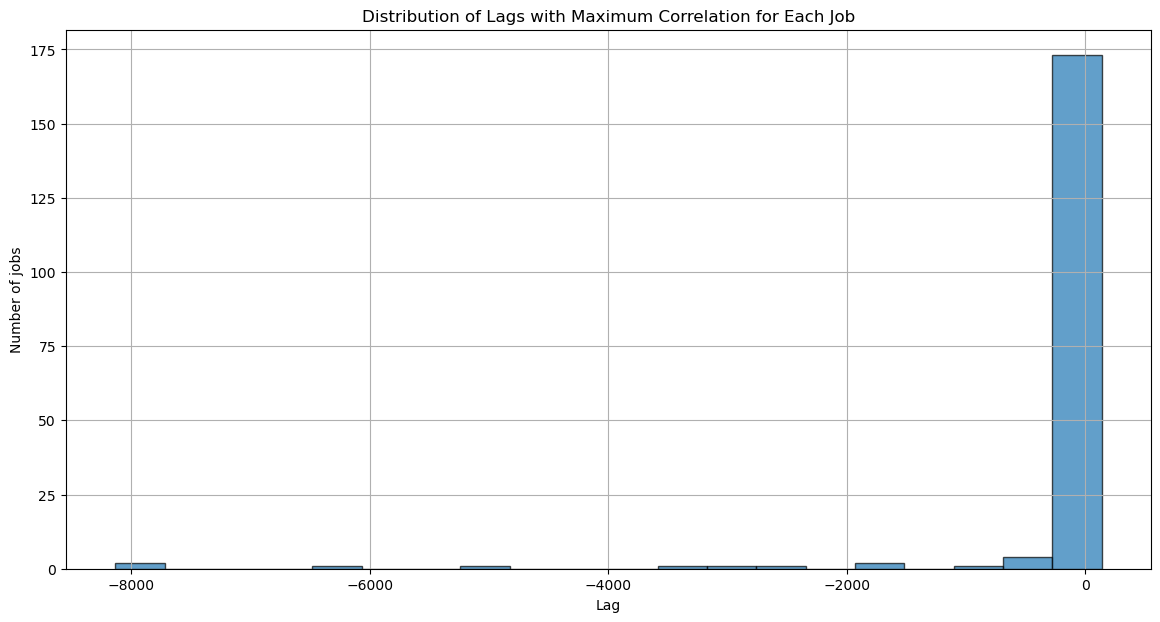

In [50]:
# find the lag with maximum correlation for each job
def find_max_corr_lag(group):
    gpu_utilization = group['gpu_utilization'].values
    tensor_active = group['tensor_active'].values
    corr = signal.correlate(gpu_utilization, tensor_active)
    lags = signal.correlation_lags(len(gpu_utilization), len(tensor_active))
    corr /= np.max(corr)
    max_corr_index = np.argmax(corr)
    lag = lags[max_corr_index]
    return lag

max_corr_lags = merged_tensor_gpu.groupby('jobid').apply(find_max_corr_lag).reset_index()
max_corr_lags.columns = ['jobid', 'max_corr_lag']

# Plotting the distribution of lags
plt.figure(figsize=(14, 7))
plt.hist(max_corr_lags['max_corr_lag'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Lags with Maximum Correlation for Each Job')
plt.xlabel('Lag')
plt.ylabel('Number of jobs')
plt.grid(True)
plt.show()

## Other ideas I have in mind:
- Isolate jobs identified as deep learning and see if the correlations are stronger or different compared to other jobs.